In [9]:
import pandas as pd
data=pd.read_csv('D:\document\Desktop\data.csv')
data['date']=pd.to_datetime(data['date'])
data = data.sort_values(by=['date','ticker']).reset_index(drop=True)
time=data['date'].unique()

In [111]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import warnings
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
simplefilter(action='ignore', category=FutureWarning)
def feature_engineering(df):
    window_size=[5,10,20,40]
    df['daily_return']=df['last'].pct_change()
    df['volume_return']=df['volume'].pct_change()
    df['target']=df['daily_return'].shift(-1)
    df = df.replace([np.inf, -np.inf], np.nan)  
    df=df.dropna()
    df=df.reset_index(drop=True)
    features=df[df.columns[2:-1]].copy(deep=True)
    #self-attention using KNN to find the nearest neighbors
    k = 5
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns)
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
    factor_values = []
    for index in range(k, len(features)):
        knn.fit(features.iloc[:index])
        distances, indices = knn.kneighbors(features.iloc[index].values.reshape(1, -1))
        neighbor_returns = df.loc[indices[0], 'target']
        factor_values.append(neighbor_returns.mean())
    df.loc[k:,'neighbor_return'] = factor_values
    df=df.dropna()
    for i in window_size:
        df[f'last_vol_corr{i}']=df['last'].rolling(i).corr(df['volume'])
        df[f'rolling_skew_last{i}']=df['last'].rolling(i).skew()
        df[f'rolling_kurt_last{i}']=df['last'].rolling(i).kurt()
        df[f'rolling_skew_volume{i}']=df['volume'].rolling(i).skew()
        df[f'rolling_kurt_volume{i}']=df['volume'].rolling(i).kurt()
    df['VWAP'] = (df['last'] * df['volume']).cumsum() / df['volume'].cumsum()
    df['VWAP_ratio'] = df['last'] / df['VWAP']
    df['VWAP_diff'] = df['last'] - df['VWAP']
    df['ewma_volatility'] = df['last'].ewm(span=14).std() * np.sqrt(252)
    df = df.replace([np.inf, -np.inf], np.nan)  
    df=df.dropna()
    del df['last']
    return df
data=data.groupby('ticker').apply(feature_engineering).reset_index(drop=True)
# data.to_csv('D:\document\desktop\processed_data.csv',index=False)


In [14]:
def feature_engineering(df):
    window_size=[5,10,20,40]
    df['daily_return']=df['last'].pct_change()
    df['volume_return']=df['volume'].pct_change()
    df['target']=df['daily_return'].shift(-1)
    return df
temp=data.groupby('ticker').apply(feature_engineering).reset_index(drop=True)

In [30]:
import pandas as pd
data=pd.read_csv('D:\document\Desktop\processed_data.csv')
data['date']=pd.to_datetime(data['date'])
time=data['date'].unique()

In [194]:
time=data['date'].unique()
def fill(df):
    df=df.set_index('date')
    df=df.reindex(time,method='ffill')
    df=df.reset_index()
    return df
data=data.groupby('ticker').apply(fill).reset_index(drop=True).dropna()

In [33]:
data=data.replace([-np.inf,np.inf],np.nan).dropna()

In [34]:
split_date=time[int(len(time)*0.7)]
is_data=data[data['date']<=split_date]
os_data=data[data['date']>split_date]
is_data_date=is_data['date'].unique()
train_test_split_date=is_data_date[int(len(is_data_date)*0.7)]
train=is_data[is_data['date']<=train_test_split_date]
test=is_data[is_data['date']>train_test_split_date]

x_train,y_train=train.drop(['ticker','date','target'],axis=1),train['target']
x_test,y_test=test.drop(['ticker','date','target'],axis=1),test['target']

In [35]:
##I use the in-sample training sets to train a Xgboost model to combined the factors to predict the target
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb
import numpy as np
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(4, 10)),
    'n_estimators': hp.choice('n_estimators', range(50, 400)),
}
def objective(params, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for train_index, test_index in tscv.split(train):
        X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model = xgb.XGBRegressor(
            learning_rate=params['learning_rate'],
            max_depth=int(params['max_depth']),
            n_estimators=int(params['n_estimators']),
            objective='reg:squarederror'
        )
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        rmses.append(rmse)
    return {'loss': np.mean(rmses), 'params': params, 'status': STATUS_OK}
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    verbose=2
)

print("Best hyperparameters found:")
print(best)

100%|██████████| 20/20 [1:41:02<00:00, 303.13s/trial, best loss: 0.02236537235980576]
Best hyperparameters found:
{'learning_rate': 0.022150049311609136, 'max_depth': 3, 'n_estimators': 215}


In [36]:
model=xgb.XGBRegressor(learning_rate=best['learning_rate'],
            max_depth=int(best['max_depth']),
            n_estimators=int(best['n_estimators']),
            objective='reg:squarederror')
model.fit(x_train,y_train)
model.save_model('D:\document\desktop\XGBoost.model')
# model=xgb.Booster()
# model.load_model('D:\document\desktop\XGBoost.model')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


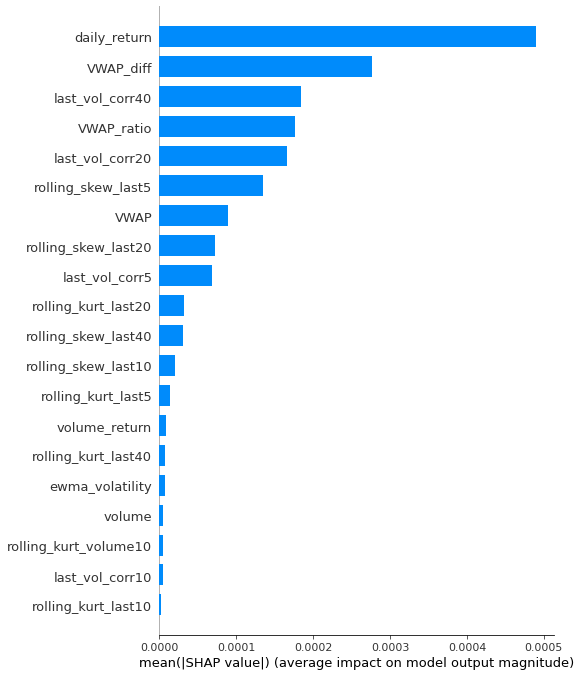

In [55]:
import shap
import matplotlib.pyplot as plt
#Visiualize the feature importance of the model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")
plt.show()

In [70]:
##This is a simple multi-factor strategy, I use the in-sample test data to adjust the parameter of the strategy
import numpy as np
import pandas as pd
from cvxpy import Variable, Problem, Maximize, quad_form, sum
import cvxpy as cp
import itertools
# eff_day=20
Best_k=[5,10,15,20]
Eff_day=[10,20,40]
# Optimization of portfolio, adjusting the weights of the target stocks
def optimize_portfolio(cov_matrix, expected_returns,best_k,coef=15000):
    max_weight=2/best_k
    weights = Variable(best_k)
    portfolio_variance = quad_form(weights, cov_matrix)
    expected_portfolio_return = expected_returns.T @ weights
    target_func = expected_portfolio_return-coef*portfolio_variance
    objective = Maximize(target_func)
    
    constraints = [
        sum(weights) == 1,
        weights >= 0,
        weights <= max_weight,
    ]
    
    prob = Problem(objective, constraints)
    prob.solve()
    return weights.value

best_sharp=-np.inf
candidate_k=0
candidate_day=0
Pnl=[]
def backtest(test, model, best_k, eff_day=20):
    test_dates = test['date'].unique()

    initial_portfolio_value = 1
    portfolio_value = initial_portfolio_value
    transaction_cost_rate = 0.001
    previous_positions = pd.DataFrame(data={'ticker': [], 'position_value': []})
    prev_top_stocks=[]
    daily_pnl = []

    previous_weights=np.zeros(best_k)
    for i,date in enumerate(test_dates[eff_day-1:]):
    # for i,date in enumerate(test_dates):
        daily_data = test[test['date'] == date]
        ## Choose effective stocks which have records for eff_day days in the past
        start_date=test_dates[i]
        end_date=test_dates[i+eff_day-1]
        recent_data=data[(data['date']>=start_date)&(data['date']<=end_date)]
        stock_counts = recent_data['ticker'].value_counts()
        active_stocks = stock_counts[stock_counts == eff_day].index.tolist()
        daily_data = daily_data[daily_data['ticker'].isin(active_stocks)]


        X_test = daily_data.drop(['ticker', 'date', 'target'], axis=1)
        y_pred = model.predict(X_test)
    
        post_top_stocks = daily_data.iloc[y_pred.argsort()[-best_k:]]
        cov_matrix = np.array(recent_data[recent_data['ticker'].isin(post_top_stocks['ticker'])].pivot(index='date', columns='ticker', values='daily_return').cov())
        expected_returns = y_pred[y_pred.argsort()[-best_k:]]
        post_weights = optimize_portfolio(cov_matrix, expected_returns,best_k)
        if i==0:
            current_positions = pd.DataFrame(data={'ticker': post_top_stocks['ticker'].values, 'position_value': portfolio_value * post_weights})
            portfolio_value-=np.sum(current_positions['position_value']*transaction_cost_rate)
        if i>=1:
            intersect=list(set(daily_data['ticker']).intersection(set(prev_top_stocks['ticker'])))
            invalid_stocks=list(set(prev_top_stocks['ticker'])-set(daily_data['ticker']))
            # portfolio_value+=np.sum(previous_positions[previous_positions['ticker'].isin(invalid_stocks)]['position_value']*transaction_cost_rate)
            previous_positions=previous_positions[~previous_positions['ticker'].isin(invalid_stocks)]

            daily_returns = daily_data.loc[daily_data['ticker'].isin(previous_positions['ticker']),'daily_return'].values
            daily_portfolio_return = np.dot(previous_positions['position_value'], daily_returns)
            # daily_portfolio_return = np.mean(daily_returns)
            portfolio_value += daily_portfolio_return
            daily_pnl.append(daily_portfolio_return/portfolio_value)

            current_positions = pd.DataFrame(data={'ticker': post_top_stocks['ticker'].values, 'position_value': portfolio_value * post_weights})
            merged_positions = previous_positions.merge(current_positions, on='ticker', how='outer', suffixes=('_prev', '_curr')).fillna(0)
            transaction_costs = np.abs(merged_positions['position_value_prev'] - merged_positions['position_value_curr']) * transaction_cost_rate
            portfolio_value -= np.sum(transaction_costs)

            
        prev_top_stocks = post_top_stocks
        previous_positions = current_positions
    return daily_pnl
for best_k,eff_day in itertools.product(Best_k,Eff_day):
    daily_pnl=backtest(test, model, best_k,eff_day)
    temp_sharp=np.mean(daily_pnl)/np.std(daily_pnl)
    print('best_k:',best_k,'eff_day:',eff_day,'sharp:',temp_sharp)
    if temp_sharp>best_sharp: 
        candidate_k=best_k
        candidate_day=eff_day
        Pnl=daily_pnl
        best_sharp=np.mean(daily_pnl)/np.std(daily_pnl)
   

best_k: 5 eff_day: 10 sharp: 0.034436759796742135
best_k: 5 eff_day: 20 sharp: 0.032964406148992084
best_k: 5 eff_day: 40 sharp: 0.03332410552619641
best_k: 10 eff_day: 10 sharp: 0.07388777912828237
best_k: 10 eff_day: 20 sharp: 0.04319012010123569
best_k: 10 eff_day: 40 sharp: 0.06621817644322488
best_k: 15 eff_day: 10 sharp: 0.06524010251978545
best_k: 15 eff_day: 20 sharp: 0.029308831040200784
best_k: 15 eff_day: 40 sharp: 0.04010660825442764
best_k: 20 eff_day: 10 sharp: 0.0559521803009472
best_k: 20 eff_day: 20 sharp: 0.02568626018257416
best_k: 20 eff_day: 40 sharp: 0.03882622882272662


Annual Return:  0.19714628645429788
Annual Std:  0.16511002432770044
Sharpe Ratio:  1.1940297826073467
Max Drawdown:  -0.12914984024977388
Calmar Ratio:  1.5264926853414598


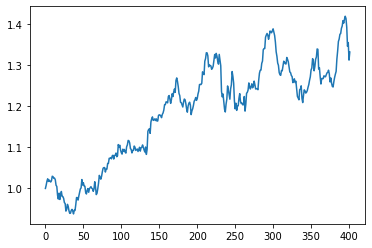

In [77]:
def annual_return(daily_pnl):
    return np.prod(1+np.array(daily_pnl))**(252/len(daily_pnl))-1
def annual_std(daily_pnl):
    return np.std(daily_pnl)*np.sqrt(252)
def sharpe_ratio(daily_pnl):
    return annual_return(daily_pnl)/annual_std(daily_pnl)
def max_drawdown(daily_pnl):
    max_value=0
    max_drawdown=0
    cur=1
    for i in range(len(daily_pnl)):
        cur*=(1+daily_pnl[i])
        max_value=max(max_value,cur)
        cur_drawdown=(cur-max_value)/max_value
        max_drawdown=min(max_drawdown,cur_drawdown)
    return max_drawdown
def calmar_ratio(daily_pnl):
    return annual_return(daily_pnl)/np.abs(max_drawdown(daily_pnl))

def summary(daily_pnl):
    print('Annual Return: ',annual_return(daily_pnl))
    print('Annual Std: ',annual_std(daily_pnl))
    print('Sharpe Ratio: ',sharpe_ratio(daily_pnl))
    print('Max Drawdown: ',max_drawdown(daily_pnl))
    print('Calmar Ratio: ',calmar_ratio(daily_pnl))
    daily_pnl.insert(0,0)
    plt.plot(np.cumprod(1+np.array(daily_pnl)))
    plt.show()
summary(Pnl)

In [68]:
os_data=os_data.reset_index(drop=True)

Annual Return:  0.09356864033572587
Annual Std:  0.33006325984030155
Sharpe Ratio:  0.2834869908907714
Max Drawdown:  -0.4488062591457262
Calmar Ratio:  0.2084833676647642


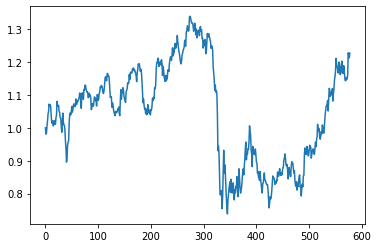

In [78]:
backtest_pnl=backtest(os_data,model,candidate_k,candidate_day)
summary(backtest_pnl)
